<div style="background-color:
#A80828; 
            color:white; 
            padding:15px; 
            border-radius:10px; 
            text-align:center; 
            font-size:30px; 
            font-weight:bold;">
    BDA 2025: Classifying Signals from Physical Activity <br>
    <span style="font-size:20px; font-weight:normal;">
        Group 1: Oliver Hutton, Julian Wuth & Kitty Hannan
    </span>
</div>

<div style="background-color:#A80828; 
            color:white; 
            padding:12px; 
            border-radius:8px; 
            font-size:24px; 
            font-weight:bold;">
    Introduction
</div>

<br>
This competition aimed to classify signal data into 12 activity types from Data was collected from 30 subjects and consists of continuous raw signals, from which frequency-domain, time-domain and statistical features were extracted, leading to a high-dimensional combined dataset.  Principal Component Analysis was applied and a range of supervised learning methods were tested before thorough performance measurement for final selection and classification on unseen data.


<br> Our expectations of what level of accuracy is theoretically possible are benchmarked by the Bayes' lower bound. Although there is a lack of data on human ability to classify activity this way, previous research ([Jalal et al., 2020](https://pmc.ncbi.nlm.nih.gov/articles/PMC7700540/)) has found accuracies from 82% up to 95% depending on the dataset.


<div style="background-color:#A80828; 
            color:white; 
            padding:12px; 
            border-radius:8px; 
            font-size:24px; 
            font-weight:bold;">
    Table of Contents
</div>

<br>


1. Reading the Data<br>
   1.1 Import Activity Labels<br>
   1.2 Importing and Merging Signals and Labels

3. Feature Extraction<br>
   2.1 Time Domain Features<br>
   2.2 Frequency Domain Features<br>
   2.3 Statistical Features

4. Putting It All Together

5. Model Fitting

6. Submissions<br>
   5.1 Formatting the Submission File

7. Division of Labour

8. References

<h1 style="background-color:#A80828; color:white; padding:12px; border-radius:8px; font-size:24px; font-weight:bold;">1. Reading the data</h1>

<br>The data are stored in plain text files; signal files comprised of accelerometer and gyroscope recordings from a range of experiments and subjects, as well as label files storing activity type labels for all experiments at time intervals.

To analyze the data, signals and labels need to be merged.

In [1]:
library(tidyverse) 
options(width=100)

list.files(path = "../input")

# Copy all files to the working directory
system(paste0("cp -r ", list.files("../input", full.names=TRUE), "/* ./"))

# list files in the current working directory
list.files()

# show the content of the labels file 
file.show("activity_labels.txt")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "bda-2025-physical-activity-signals-classification"

[1] "__notebook__.ipynb"     "activity_labels.txt"    "example_submission.csv"
[4] "RawData"                "README.txt"

<h2 style="background-color:#C91E3A; color:white; padding:10px; border-radius:6px; font-size:20px; font-weight:normal;">1.1 Import Activity labels</h2>

<br>First we import the 12 activity labels:

In [2]:
act_labels = read.table("activity_labels.txt", header=FALSE, col.names=c('code','activity')) 
act_labels

code,activity
<int>,<chr>
1,WALKING
2,WALKING_UPSTAIRS
3,WALKING_DOWNSTAIRS
4,SITTING
5,STANDING
6,LAYING
7,STAND_TO_SIT
8,SIT_TO_STAND
9,SIT_TO_LIE


Each signal file contains three columns, one for each sensor channel (X, Y and Z directions). The file consists of a sequence of measurements, called samples, with each row representing one time point.

In [3]:
labels0 = read_delim("./RawData/Train/labels_train.txt", delim=" ", 
                    col_names = c('trial', 'userid', 'act_code', 'start', 'end'), col_types="iiiii")

#joining activity codes from labels.txt w the descriptive labels in activity_labels
labels = labels0 |> left_join(act_labels, by=c(act_code = "code"))

<h2 style="background-color:#C91E3A; color:white; padding:10px; border-radius:6px; font-size:20px; font-weight:normal;">1.2 Importing and merging signals and labels</h2>

In [4]:
# file path
filename <- "RawData/Train/acc_exp01_user01.txt"

# extract parts of the filename
username <- str_extract(filename, "(?<=user)\\d+") |> as.integer()
expname  <- str_extract(filename, "(?<=exp)\\d+") |> as.integer()

# import the data
user01 <- read_delim(filename, delim = " ", col_names = FALSE, col_types = "ddd")

#expanding into a table w activity label for every sample
sample_labels <- labels |>
  mutate(segment = row_number()) |>         # identify each separate activity interval
  reframe(
    sampleid = seq.int(start, end),          # expand start:end into all sample IDs
    .by = c(trial, userid, act_code, activity, segment)
  )

#merging user/trial/sample data with signal columns and labels
user_df = 
  tibble(userid = username, trial = expname, sampleid = seq.int(0, nrow(user01) - 1)) |>
  bind_cols(user01) |>
  left_join(sample_labels, by = c("userid", "trial", "sampleid"))

<h1 style="background-color:#A80828; color:white; padding:12px; border-radius:8px; font-size:24px; font-weight:bold;">2. Feature Extraction</h1>

<h2 style="background-color:#C91E3A; color:white; padding:10px; border-radius:6px; font-size:20px; font-weight:normal;">2.1 Time domain features</h2>

Raw time samples are not useful features intially because we don’t know in advance how many samples a typical pattern spans, and patterns can be shifted so cycles don’t always line up.

Instead, we compute features that don’t depend on time shifts or take them into account, for example correlating with a time-shifted variable.

### 2.1.1 Feature justification

Correlation between the different sensors could capture coordination between the different axes of movement. For instance, when walking downstairs, two of the sensors would be highly correlated, but this wouldn't be the case when simply standing or sitting. In order to detect delayed relationships, we included lagged correlation, with 2 different time shifts. We also consider autocorrelation, which looks at the similarity between a signal and it's own time shifted version. In cases where there is smooth or minimal movement (e.g., sitting), the autocorrelation with Lag-1 would be high, whereas abrupt movement (e.g. walking) would result in lower autocorrelation.

Zero-crossing rate and slope sign changes are common time domain features used in signal extraction. In essence, they both capture how much oscillation there is in a specific time range - that is, how active someone is. In more dynamic activities, such as walking, both of these values would be quite high, while in less dynamic activities, they would be low.

In [5]:
# Helper functions
most_common_value = function(x) {
    counts = table(x, useNA='no')
    most_frequent = which.max(counts)
    return(names(most_frequent))
}

## Correlation and lagged correlation
# set default lag to 0 for normal correlation, and y to x for autocorrelation
lagged_cor = function(x, y=x, lag=0) {
    # compute correlation between x and a time shifted y
    r_lagged = cor(x, dplyr::lag(y, lag), use='pairwise')
    return(r_lagged)
}

# number of times signal crosses x-axis --> how much oscillation is there in an epoch
zero_cross_rate = function(x) {
    zcr <- sum(diff(sign(x)) != 0)
    return(zcr)
}

# number of times signal changes sign --> how much oscillation is there in an epoch
slope_sign_changes = function(x) {
    ssc <- sum(diff(sign(diff(x))) != 0)
    return(ssc)
}

<h2 style="background-color:#C91E3A; color:white; padding:10px; border-radius:6px; font-size:20px; font-weight:normal;">2.2 Frequency domain features</h2>

### 2.2.1 Feature justification

The first few features (i.e., mean, sd, skewness, kurtosis) are all statistics derived by treating the spectrum as a density. Based on the video that was provided, it became clear that, for example, dynamic actions seem to exhibit oscillations at higher frequencies than static postures. This would result in differences in the mean frequency. The other moments pick up the following differences: 
- Is the action defined by spanning oscillations of many different frequencies (sd)?
- Is the action more defined by low frequency oscillations rather than high frequency oscillations or vice versa (skewness)?
- Does the action exhibit mostly similar frequencies with occasionally very high or low frequencies (outliers) or does it cover the spectrum more evenly (kurtosis)?

As another example, consider one of the static postures (e.g., sit-to-stand). When sitting and standing, the frequencies do not seem to change a lot, but the change from sitting to standing should be defined by outling frequencies compared to the frequency when a person is in one of the states. This might be well summarised by high kurtosis. In contrast, the dynamic movements may have lower kurtosis. 

The frequency centroid is a feature that combines all three inputs (i.e., X1, X2, X3). Therefore, it could, for example, detect whether actions differ in their frequencies across all axes instead of focusing on each of the axes separately. 

The remaining features are based on spectral bands. Features like spectral entropy and flatness could differentiate actions that are concentrated, meaning they have high power in one or a few bands (e.g., sit-to-stand), from actions that are more noisy and span more bands equally (e.g., dynamic actions). The ratio of minimal to maximal power across the bands does something similar. If there is one dominant band, the maximal power will be a lot larger than the minimum power. If the power is evenly distributed across the bands, minimum and maximum power are more similar.

The total power is probably also different between actions. Based on the example video, dynamic actions, like walking, seem to show more oscillations overall (high total power) than the static postures, which are defined by mostly flat lines.

Just as sleep stages are associated with dominant activity in different bands, movements might show a similar pattern. Therefore, I also extracted the spectrum with the largest power and the one with the lowest power.



In [6]:
# Helper functions

# get_band_power <- function(freq, spec, n) {
#     bands <- seq(0, max(freq), len = n) # define n bands
#     df <- tibble(freq, spec) |> 
#         mutate(band = findInterval(freq, bands)) |>  # find band to which freq belongs
#         group_by(band) |>
#         summarise(
#             band_power = mean(spec), # power for each band
#             band_peak_freq = freq[which.max(spec)],
#             bandwidth = diff(bands)[1]
#         ) 
#     return(df)  
# }

# Note: The get_band_power function above was really slow because of the tidyverse
# operations, so we requested a faster (base R) version from an LLM (see below)

# ==> START LLM
get_band_power <- function(freq, spec, n) {
    # Define bands
    bands <- seq(0, max(freq), length.out = n)
    bandwidth <- diff(bands)[1]
    
    # Assign each freq to a band
    band <- findInterval(freq, bands)
    
    band_power <- tapply(spec, band, mean)
    band_peak_freq <- tapply(seq_along(spec), band, function(i) freq[i[which.max(spec[i])]])
    
    data.frame(
    band = seq_len(n),
    band_power = band_power,
    band_peak_freq = band_peak_freq,
    bandwidth = bandwidth
    )
}
# ==> END LLM
                             
most_common_value = function(x) {
    counts = table(x, useNA = 'no')
    most_frequent = which.max(counts)
    return(names(most_frequent))
}

# Feature functions (frequency domain)
mean_frequency <- function(freq, spec) { 
    delta_f = freq[2] - freq[1]  # gap size between frequencies
    normalizing_constant = sum(spec * delta_f) # ≈ ∫S(f)df
    mean_freq = sum(freq * spec * delta_f) / normalizing_constant
    return(mean_freq)
}

centroid_frequency <- function(freq, spec1, spec2, spec3) {
    spec_total <- spec1 + spec2 + spec3
    delta_f <- diff(freq)[1]
    c <- sum(spec_total * delta_f) # normalising constant
    centroid <- sum(freq * spec_total * delta_f) / c
    return(centroid)
}

sd_frequency <- function(freq, spec) {
    delta_f <- freq[2] - freq[1]  # gap size between frequencies
    normalizing_constant <- sum(spec * delta_f) # ≈ ∫S(f)df
    mean_freq <- mean_frequency(freq, spec)
    var_freq <- sum((freq - mean_freq)^2 * spec * delta_f) / normalizing_constant 
    return(sqrt(var_freq))
}

skew_frequency <- function(freq, spec) {
    sd_freq <- sd_frequency(freq, spec)
    delta_f <- freq[2] - freq[1]  # gap size between frequencies
    normalizing_constant <- sum(spec * delta_f) # ≈ ∫S(f)df
    
    mean_freq <- mean_frequency(freq, spec)
    skew <- sum((freq - mean_freq)^3 * spec * delta_f) / (normalizing_constant * sd_freq^3)
    return(skew)
}

kurtosis_frequency <- function(freq, spec) {
    sd_freq <- sd_frequency(freq, spec)
    delta_f <- freq[2] - freq[1]  # gap size between frequencies
    normalizing_constant <- sum(spec * delta_f) # ≈ ∫S(f)df
    
    mean_freq <- mean_frequency(freq, spec)
    k <- sum((freq - mean_freq)^4 * spec * delta_f) / (normalizing_constant * sd_freq^4)
    return(k - 3) # this is the excess kurtosis
}

spec_flatness <- function(freq, spec) {
    bandwidth <- diff(range(freq))
    df <- diff(freq)[1]
    num <- exp(sum(log(spec) * df) / bandwidth) # geometric mean
    denom <- sum(spec * df) / bandwidth # arithmetic mean
    return(num / denom)
}

spec_entropy <- function(freq, spec) {
    band_power <- get_band_power(freq, spec, 8)$band_power # 8 bands
    
    # compute spectral entropy
    pow_norm <- band_power / sum(band_power) # normalise
    ent <- -sum(log(pow_norm) * pow_norm)
    return(ent)
}

total_power <- function(freq, spec) {
    band_df <- get_band_power(freq, spec, 8) # 8 bands
    return(sum(band_df$band_power * band_df$bandwidth))
}

power_ratio <- function(freq, spec) {
    band_power <- get_band_power(freq, spec, 8)$band_power
    res <- min(band_power) / max(band_power)
    return(res)
}

bandpower_low <- function(freq, spec) {
    df <- get_band_power(freq, spec, 8) # 8 bands
    bands <- df[order(df$band_power), ]$band # base R to make function faster
    return(bands[1]) # return band with lowest power
}

bandpower_high <- function(freq, spec) {
    df <- get_band_power(freq, spec, 8) # 8 bands
    bands <- df[order(df$band_power, decreasing = TRUE), ]$band # base R to make function faster
    return(bands[1]) # return band with highest power
}

Creating a function for computing the frequency domain features:

In [7]:
compute_freq_features <- function(user_spect_df) {
    userfreqdom <- user_spect_df |>
        group_by(epoch) |>
        drop_na() |> # only compute features when spectrum() ran
        summarise(

            # Dominant frequencies
            domfreq1 = freq[which.max(spec1)],
            domfreq2 = freq[which.max(spec2)],
            domfreq3 = freq[which.max(spec3)],
    
            # Mean frequencies 
            meanfreq1 = mean_frequency(freq, spec1),
            meanfreq2 = mean_frequency(freq, spec2),
            meanfreq3 = mean_frequency(freq, spec3),
    
            # Frequency centroid
            centrfreq = centroid_frequency(freq, spec1, spec2, spec3),
            
            # sd of frequencies
            sdfreq1 = sd_frequency(freq, spec1),
            sdfreq2 = sd_frequency(freq, spec2),
            sdfreq3 = sd_frequency(freq, spec3),
    
            # Skewness
            skewfreq1 = skew_frequency(freq, spec1),
            skewfreq2 = skew_frequency(freq, spec2),
            skewfreq3 = skew_frequency(freq, spec3),
    
            # Kurtosis
            kurtfreq1 = kurtosis_frequency(freq, spec1),
            kurtfreq2 = kurtosis_frequency(freq, spec2),
            kurtfreq3 = kurtosis_frequency(freq, spec3),
            
            # Spectral flatness
            specFlat1 = spec_flatness(freq, spec1),
            specFlat2 = spec_flatness(freq, spec2),
            specFlat3 = spec_flatness(freq, spec3),
            
            # Spectral entropies
            specEntr1 = spec_entropy(freq, spec1),
            specEntr2 = spec_entropy(freq, spec2),
            specEntr3 = spec_entropy(freq, spec3),
    
            # Total power across bands
            totPow1 = total_power(freq, spec1),
            totPow2 = total_power(freq, spec2),
            totPow3 = total_power(freq, spec3),
    
            # Ratio of min to max power
            ratPow1 = power_ratio(freq, spec1),
            ratPow2 = power_ratio(freq, spec2),
            ratPow3 = power_ratio(freq, spec3),
            
            # Band with minimum power
            bandpower_low1 = bandpower_low(freq, spec1),
            bandpower_low2 = bandpower_low(freq, spec2),
            bandpower_low3 = bandpower_low(freq, spec3),
            
            # Band with maximum power
            bandpower_high1 = bandpower_high(freq, spec1),
            bandpower_high2 = bandpower_high(freq, spec2),
            bandpower_high3 = bandpower_high(freq, spec3)
        )
        return(userfreqdom)
}


<h2 style="background-color:#C91E3A; color:white; padding:10px; border-radius:6px; font-size:20px; font-weight:normal;">2.3 Statistical features</h2>

In [8]:
#the mean across the samples of a signal
level <- function(x) {
    1/length(x) * sum(x)
}

#the average squared amplitude of the signal 
#\"deviation from an absolute 0, does not depend on polarity
power <- function(x){
    mean(x^2) 
}

#total power of the samples
energy <- function(x) {
    length(x) * mean(x^2)
}

#represents the information content/uncertainty of a signal
entropy <- function(x, nbreaks = nclass.Sturges(x)) {
    r = range(x)
    x_binned = findInterval(x, seq(r[1], r[2], len= nbreaks))
    h = tabulate(x_binned, nbins = nbreaks)
    p = h/sum(h)
    -sum(p[p>0] * log(p[p>0]))
}

mode <- function(x) {
    as.numeric(names(which.max(table(x))))
}

stError <- function(x) {
    sd(x)/sqrt(length(x))
}

mean_x_y2 <- function(x, y) {
    mean(x * y^2)
}

#inspired by group 5, trend fits a linear regression and reports the overall
#slope of the activity signal
trend = function(x) {
  t = 1:length(x)
  if(length(x) < 2) return(NA)
  beta1 = cov(x, t) / var(t)
  return(beta1)
}

<h1 style="background-color:#A80828; color:white; padding:12px; border-radius:8px; font-size:24px; font-weight:bold;">3. Putting it all together</h1>

In [9]:
extractFrequencyDomainFeatures <- function(file_name, sample_labels) {
    # extract user and experimental run ID's from file name
    username <- str_extract(file_name, "(?<=user)\\d+") |> as.integer()
    expname  <- str_extract(file_name, "(?<=exp)\\d+") |> as.integer()
    
    # import the sensor signals from the file
    user01 <- read_delim(
        file_name, 
        delim = " ", 
        col_names = FALSE, 
        progress = TRUE, 
        col_types = "ddd"
    )
    
    
    # merge signals with labels 
    user_df <- 
        tibble(userid = username, trial = expname, sampleid = seq.int(0, nrow(user01) - 1)) |>
        bind_cols(user01) |>
        left_join(sample_labels, by = c("userid", "trial", "sampleid"))

    # describe what happens here
    user_spect_df <- user_df |>
        mutate(epoch = sampleid %/% 128) |>    
        reframe({
        sp <- try(
            spectrum(cbind(X1, X2, X3), span = 15, plot = FALSE), silent = T
        ) # if epochs have to little samples it fails
        if (class(sp) != "try-error") {
            tibble(
              freq  = sp$freq,                 # cycles per sample
              spec1 = sp$spec[, 1],
              spec2 = sp$spec[, 2],
              spec3 = sp$spec[, 3]
            )  
        } else { # add NAs in case the spectrum function does not run
            tibble(
              freq  = NA,                 
              spec1 = NA,
              spec2 = NA,
              spec3 = NA  
            )
        }
        }, .by = epoch)

    user_df <- user_df |>
        mutate(epoch = sampleid %/% 128) |>
        group_by(epoch) |>
        summarise(
            # Keep track of user and experiment information
            user_id = username, 
            exp_id = expname,
                
            # Activity label for the epoch = most common value (mode)
            activity = most_common_value(c("-", activity)),
            
            # Keep starting sample ID of the epoch
            sampleid = sampleid[1],

            n_samples = n()
        )

    # compute frequency-domain features per epoch
    userfreqdom <- compute_freq_features(user_spect_df)

    # join with user_df
    out <- user_df |>
        left_join(userfreqdom, by = "epoch")

    return(out)
}

In [10]:
extractTimeDomainFeatures <- function(filename, sample_labels) {
    
    # extract user and experimental run ID's from file name
    username <- str_extract(filename, "(?<=user)\\d+") |> as.integer()
    expname  <- str_extract(filename, "(?<=exp)\\d+") |> as.integer()
    
    # import the sensor signals from the file
    user01 <- read_delim(filename, delim = " ", col_names = FALSE, progress = TRUE,
                 col_types = "ddd")
    
    
    # merge signals with labels 
    user_df <- 
      tibble(userid = username, trial = expname, sampleid = seq.int(0, nrow(user01) - 1)) |>
      bind_cols(user01) |>
      left_join(sample_labels, by = c("userid", "trial", "sampleid"))

      usertimedom <- user_df |>  
      # partition into epochs and add an epoch ID variable (one epoch = 2.56 sec)
      mutate(epoch = sampleid %/% 128) |>
    
      # extract statistical features from each epoch
      group_by(epoch) |>
      summarise(
          # Keep track of user and experiment information
          user_id = username, 
          exp_id = expname,   
          
          # Activity label for the epoch = most common value (mode)
          activity = most_common_value(c("-", activity)),
    
          # Keep starting sample ID of the epoch
          sampleid = sampleid[1],
      
          #Auto-correlation with different lag
          AR1_X1_lag1 = lagged_cor(X1, lag=1),
          AR1_X1_lag2 = lagged_cor(X1, lag=2),
          AR1_X1_lag3 = lagged_cor(X1, lag=3),
          AR1_X1_lag4 = lagged_cor(X1, lag=4),
          AR1_X2_lag1 = lagged_cor(X2, lag=1),
          AR1_X2_lag2 = lagged_cor(X2, lag=2),
          AR1_X2_lag3 = lagged_cor(X2, lag=3),
          AR1_X2_lag4 = lagged_cor(X2, lag=4),
          AR1_X3_lag1 = lagged_cor(X3, lag=1),
          AR1_X3_lag2 = lagged_cor(X3, lag=2),
          AR1_X3_lag3 = lagged_cor(X3, lag=3),
          AR1_X3_lag4 = lagged_cor(X3, lag=4),

          #Correlation between sensors (no lag)
          cor_X1X2 = cor(X1, X2),
          cor_X1X3 = cor(X1, X3),
          cor_X2X3 = cor(X2, X3),
      
          #Cross-lagged correlation between different sensors
          AR_X1X2_lag1 = lagged_cor(X1, X2, lag=1),
          AR_X1X2_lag2 = lagged_cor(X1, X2, lag=2),
          AR_X1X2_lag3 = lagged_cor(X1, X2, lag=3),
          AR_X1X2_lag4 = lagged_cor(X1, X2, lag=4),
          AR_X1X3_lag1 = lagged_cor(X1, X3, lag=1),
          AR_X1X3_lag2 = lagged_cor(X1, X3, lag=2),
          AR_X1X2_lag3 = lagged_cor(X1, X3, lag=3),
          AR_X1X3_lag4 = lagged_cor(X1, X3, lag=4),
          AR_X2X3_lag2 = lagged_cor(X2, X3, lag=1),
          AR_X2X3_lag2 = lagged_cor(X2, X3, lag=2),
          AR_X2X3_lag3 = lagged_cor(X2, X3, lag=3),
          AR_X2X3_lag4 = lagged_cor(X2, X3, lag=4),
          #Must be done in both ways 
          #cor(X1, X2, lag = 2) is not the same as cor(X2, X1, lag = 2)
          cor_X2X1_lag1 = lagged_cor(X2, X1, lag=1),
          cor_X2X1_lag2 = lagged_cor(X2, X1, lag=2),
          cor_X2X1_lag3 = lagged_cor(X2, X1, lag=3),
          cor_X2X1_lag4 = lagged_cor(X2, X1, lag=4),
          cor_X3X1_lag1 = lagged_cor(X3, X1, lag=1),
          cor_X3X1_lag2 = lagged_cor(X3, X1, lag=2),
          cor_X3X1_lag3 = lagged_cor(X3, X1, lag=3),
          cor_X3X1_lag4 = lagged_cor(X3, X1, lag=4),
          cor_X3X2_lag1 = lagged_cor(X3, X2, lag=1),
          cor_X3X2_lag2 = lagged_cor(X3, X2, lag=2),
          cor_X3X2_lag3 = lagged_cor(X3, X2, lag=3),
          cor_X3X2_lag4 = lagged_cor(X3, X2, lag=4),

          #rate at which the signal crosses the x-axis
          zcr_X1 = zero_cross_rate(X1),
          zcr_X2 = zero_cross_rate(X2),
          zcr_X3 = zero_cross_rate(X3),
      
          #number of times the slope changes sign
          ssc_X1 = slope_sign_changes(X1),
          ssc_X2 = slope_sign_changes(X2),
          ssc_X3 = slope_sign_changes(X3),
      
          # Keep track of signal lengths
          n_samples = n()
  )   
    usertimedom 
}

In [11]:
extractStatFeatures <- function(filename, sample_labels) {
    
    # extract user and experimental run ID's from file name
    username <- str_extract(filename, "(?<=user)\\d+") |> as.integer()
    expname  <- str_extract(filename, "(?<=exp)\\d+") |> as.integer()
    
    # import the sensor signals from the file
    user01 <- read_delim(filename, delim = " ", col_names = FALSE, progress = TRUE,
                 col_types = "ddd")
    
    
    # merge signals with labels 
    user_df <- 
      tibble(userid = username, trial = expname, sampleid = seq.int(0, nrow(user01) - 1)) |>
      bind_cols(user01) |>
      left_join(sample_labels, by = c("userid", "trial", "sampleid"))

      user_stats <- user_df |>  
      # partition into epochs and add an epoch ID variable (one epoch = 2.56 sec)
      mutate(epoch = sampleid %/% 128) |>
    
      # extract statistical features from each epoch
      group_by(epoch) |>
      summarise(
          # Keep track of user and experiment information
          user_id = username, 
          exp_id = expname,   
          
          # Activity label for the epoch = most common value (mode)
          activity = most_common_value(c("-", activity)),
    
          # Keep starting sample ID of the epoch
          sampleid = sampleid[1],
          
          mean_X1 = mean(X1), 
          mean_X2 = mean(X2), 
          mean_X3 = mean(X3),
            
          mode_X1 = mode(X1),
          mode_X2 = mode(X2),
          mode_X3 = mode(X3),
            
          sd_X1 = sd(X1), 
          sd_X2 = sd(X2),
          sd_X3 = sd(X3),
          
          se_X1 = stError(X1),
          se_X2 = stError(X2),
          se_X3 = stError(X3),
          
          skew_X1 = e1071::skewness(X1),
          skew_X2 = e1071::skewness(X2),
          skew_X3 = e1071::skewness(X3),
          
          kurt_X1 = e1071::kurtosis(X1),
          kurt_X2 = e1071::kurtosis(X2),
          kurt_X3 = e1071::kurtosis(X3),
          
          level_X1 = level(X1),
          level_X2 = level(X2),
          level_X3 = level(X3),
          
          power_X1 = power(X1),
          power_X2 = power(X2),
          power_X3 = power(X3),
          
          energy_X1 = energy(X1),
          energy_X2 = energy(X2),
          energy_X3 = energy(X3),
          
          entropy_1 = entropy(X1), 
          entropy_2 = entropy(X2), 
          entropy_3 = entropy(X3),
          
          min_1 = min(X1),
          min_2 = min(X2),
          min_3 = min(X3),
          
          max_1 = max(X1),
          max_2 = max(X2),
          max_3 = max(X3),
          
          median_1 = median(X1),
          median_2 = median(X2),
          median_3 = median(X3),
          
          IQR_1 = IQR(X1, na.rm = TRUE),
          IQR_2 = IQR(X2, na.rm = TRUE),
          IQR_3 = IQR(X3, na.rm = TRUE),
          
          q25_X1  = quantile(X1, .25),
          q25_X2  = quantile(X2, .25),
          q25_X3  = quantile(X3, .25),
          
          mean_x1_x2_2 = mean_x_y2(X1, X2),
          mean_x2_x1_2 = mean_x_y2(X2, X1),
          mean_x1_x3_2 = mean_x_y2(X1, X3),
          mean_x3_x1_2 = mean_x_y2(X3, X1),
          mean_x2_x3_2 = mean_x_y2(X2, X3),
          mean_x3_x2_2 = mean_x_y2(X3, X2),

          trend_1 = trend(X1),
          trend_2 = trend(X2),
          trend_3 = trend(X3),
            
          # Keep track of signal lengths
          n_samples = n()
  )   
    user_stats 
}

Using `map_dfr()` to iterate through all the filenames with our new functions:

In [12]:
filenames <- dir("./RawData/Train/", pattern = "^acc", full.names = TRUE)
myDataTimeDom = map_dfr(filenames, extractTimeDomainFeatures, sample_labels) 
myDataFreq = map_dfr(filenames, extractFrequencyDomainFeatures, sample_labels)
myDataStats = map_dfr(filenames, extractStatFeatures, sample_labels)

Do the same for the gyroscope data:

In [13]:
filenames_gyro <- dir("./RawData/Train/", pattern = "^gyro", full.names = TRUE)
myDataTimeDom_gyro <- map_dfr(filenames_gyro, extractTimeDomainFeatures, sample_labels) 
myDataFreq_gyro <- map_dfr(filenames_gyro, extractFrequencyDomainFeatures, sample_labels)
myDataStats_gyro <- map_dfr(filenames_gyro, extractStatFeatures, sample_labels)

Combining all the different features into one data frame:

In [14]:
new_Data <- myDataStats %>%
    left_join(
        myDataTimeDom, 
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity")
    ) %>%
    left_join(
        myDataFreq, 
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity")
    ) %>%
    left_join(
        myDataStats_gyro, 
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity"),
        suffix = c("", "_gyro") # different colnames for gyro features
    ) %>% 
    left_join(
        myDataTimeDom_gyro,
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity"),
        suffix = c("", "_gyro")
    ) %>%
    left_join(
        myDataFreq_gyro, 
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity"),
        suffix = c("", "_gyro")
    ) %>%
    relocate(n_samples, .after = last_col())

# summary(new_Data)

<h1 style="background-color:#A80828; color:white; padding:12px; border-radius:8px; font-size:24px; font-weight:bold;">4. Model fitting</h1>

<br>We fitted a variety of different models (shown here ordered from least to most flexible) and experimented with feature reduction with Principal Component Analysis. Reducing the dimensions greatly decreased accuracy. Therefore, we present results without PCA.

In [15]:
## Fitting classifier models from ISLR Chapter 4
##

library(caret)

# Remove non-feature columns
myData2 = new_Data |> 
    select(-c("epoch","sampleid","user_id","exp_id","n_samples")) |>
    drop_na()

# without PCA
preproc = preProcess(
    myData2, 
    method=c("nzv", "corr", "center", "scale", "medianImpute"), 
    cutoff=0.95
)

# with PCA
# preproc = preProcess(myData2, method=c("nzv", "corr", "center", "scale", "medianImpute", "pca"), 
#                      thresh = 0.95, # reduce dimensions until 95% of variance is explained
#                      cutoff = 0.95)


myData2 = predict(preproc, myData2)

lincomb = myData2 |> select_if(is.numeric) |> findLinearCombos()
redundant = names(myData2 |> select_if(is.numeric))[lincomb$remove]
myData2 = myData2 |> select(-all_of(redundant))
colnames(myData2)

trcntr = trainControl("cv", 5)

Loading required package: lattice




Attaching package: ‘caret’




The following object is masked from ‘package:purrr’:

    lift




The following object is masked from ‘package:httr’:

    progress




[1] "activity"             "mode_X1"              "se_X1"                "se_X2"               
  [5] "se_X3"                "skew_X1"              "skew_X2"              "skew_X3"             
  [9] "kurt_X1"              "kurt_X2"              "kurt_X3"              "energy_X2"           
 [13] "energy_X3"            "entropy_1"            "entropy_2"            "entropy_3"           
 [17] "min_1"                "min_2"                "min_3"                "max_1"               
 [21] "max_2"                "max_3"                "median_2"             "median_3"            
 [25] "IQR_1"                "IQR_2"                "IQR_3"                "q25_X1"              
 [29] "mean_x1_x2_2"         "mean_x2_x1_2"         "mean_x1_x3_2"         "mean_x3_x1_2"        
 [33] "mean_x2_x3_2"         "mean_x3_x2_2"         "trend_1"              "trend_2"             
 [37] "trend_3"              "AR1_X1_lag1"          "AR1_X1_lag2"          "AR1_X1_lag3"         
 [41] "AR1_X1_lag4"          "AR1_X2_lag1"          "AR1_X2_lag2"          "AR1_X2_lag4"         
 [45] "AR1_X3_lag1"          "AR1_X3_lag2"          "AR1_X3_lag4"          "cor_X1X2"            
 [49] "cor_X1X3"             "AR_X1X2_lag2"         "AR_X1X2_lag4"         "AR_X1X3_lag1"        
 [53] "AR_X1X3_lag2"         "AR_X1X3_lag4"         "AR_X2X3_lag4"         "cor_X2X1_lag1"       
 [57] "cor_X2X1_lag4"        "cor_X3X1_lag1"        "cor_X3X1_lag4"        "cor_X3X2_lag4"       
 [61] "zcr_X2"               "zcr_X3"               "ssc_X1"               "ssc_X2"              
 [65] "ssc_X3"               "domfreq1"             "domfreq2"             "domfreq3"            
 [69] "centrfreq"            "sdfreq2"              "sdfreq3"              "skewfreq1"           
 [73] "skewfreq2"            "skewfreq3"            "kurtfreq1"            "kurtfreq2"           
 [77] "kurtfreq3"            "specEntr1"            "specEntr2"            "specEntr3"           
 [81] "totPow1"              "totPow2"              "totPow3"              "ratPow1"             
 [85] "ratPow2"              "ratPow3"              "bandpower_low1"       "bandpower_low2"      
 [89] "bandpower_low3"       "bandpower_high1"      "bandpower_high2"      "bandpower_high3"     
 [93] "mode_X1_gyro"         "mode_X2_gyro"         "mode_X3_gyro"         "se_X1_gyro"          
 [97] "se_X2_gyro"           "se_X3_gyro"           "skew_X1_gyro"         "skew_X2_gyro"        
[101] "skew_X3_gyro"         "kurt_X1_gyro"         "kurt_X2_gyro"         "kurt_X3_gyro"        
[105] "level_X1_gyro"        "level_X2_gyro"        "level_X3_gyro"        "power_X1_gyro"       
[109] "entropy_1_gyro"       "entropy_2_gyro"       "entropy_3_gyro"       "min_1_gyro"          
[113] "min_2_gyro"           "min_3_gyro"           "max_1_gyro"           "max_2_gyro"          
[117] "max_3_gyro"           "median_1_gyro"        "median_2_gyro"        "median_3_gyro"       
[121] "IQR_1_gyro"           "IQR_2_gyro"           "IQR_3_gyro"           "q25_X1_gyro"         
[125] "q25_X2_gyro"          "q25_X3_gyro"          "mean_x1_x2_2_gyro"    "mean_x2_x1_2_gyro"   
[129] "mean_x1_x3_2_gyro"    "mean_x3_x1_2_gyro"    "mean_x2_x3_2_gyro"    "mean_x3_x2_2_gyro"   
[133] "trend_1_gyro"         "trend_2_gyro"         "trend_3_gyro"         "AR1_X1_lag2_gyro"    
[137] "AR1_X1_lag4_gyro"     "AR1_X2_lag2_gyro"     "AR1_X2_lag4_gyro"     "AR1_X3_lag1_gyro"    
[141] "AR1_X3_lag2_gyro"     "AR1_X3_lag4_gyro"     "AR_X1X2_lag1_gyro"    "AR_X1X2_lag4_gyro"   
[145] "AR_X1X3_lag1_gyro"    "AR_X1X3_lag4_gyro"    "AR_X2X3_lag4_gyro"    "cor_X2X1_lag4_gyro"  
[149] "cor_X3X1_lag4_gyro"   "cor_X3X2_lag1_gyro"   "zcr_X1_gyro"          "zcr_X2_gyro"         
[153] "zcr_X3_gyro"          "ssc_X1_gyro"          "ssc_X2_gyro"          "ssc_X3_gyro"         
[157] "domfreq1_gyro"        "domfreq2_gyro"        "domfreq3_gyro"        "meanfreq1_gyro"      
[161] "meanfreq2_gyro"       "centrfreq_gyro"       "skewfreq1_gyro"       "skewfr

### 4.1 Linear Discriminant Analysis


In [16]:
fit_lda = train(activity ~ ., data = myData2, method="lda", trControl=trcntr)
fit_lda

Linear Discriminant Analysis 

6248 samples
 184 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 5000, 4998, 4998, 4997, 4999 
Resampling results:

  Accuracy   Kappa    
  0.8391535  0.8146382


### 4.2 Naive Bayes

In [17]:
fit_nb = train(activity ~ ., data = myData2, method = "naive_bayes", trControl = trcntr)
fit_nb

Naive Bayes 

6248 samples
 184 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4997, 4998, 5001, 5000, 4996 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE      0.6778016  0.6373424
   TRUE      0.7331954  0.6946305

Tuning parameter 'laplace' was held constant at a value of 0
Tuning parameter 'adjust' was
 held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were laplace = 0, usekernel = TRUE and adjust = 1.

### 4.3 Multinomial Regression


In [18]:
# Multinomial regression does not run when including all features
# fit_multinom = train(activity ~ ., data = myData2, method = "multinom", trControl = trcntr, trace = FALSE)
# fit_multinom

### 4.4 Quadratic Discriminant Analysis

In [19]:
# QDA does not run either because some groups are too small
# fit_qda = train(activity ~ ., data = myData2, method = "qda", trControl = trcntr)
# fit_qda

### 4.5 K-Nearest Neighbours


In [20]:
fit_knn = train(
    activity ~ ., 
    data = myData2, 
    method = "knn", 
    trControl = trcntr, 
    preProcess = "scale"
)
fit_knn

k-Nearest Neighbors 

6248 samples
 184 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

Pre-processing: scaled (184) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4999, 4996, 4999, 4998, 5000 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.8319437  0.8061234
  7  0.8306678  0.8046145
  9  0.8290677  0.8027760

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.


Call:
summary.resamples(object = rs)

Models: lda, knn, naive_bayes 
Number of resamples: 5 

Accuracy 
               Min. 1st Qu.  Median    Mean 3rd Qu.    Max. NA's
lda         0.82480  0.8336 0.84093 0.83915 0.84227 0.85417    0
knn         0.82226  0.8264 0.83333 0.83194 0.83827 0.83946    0
naive_bayes 0.72414  0.7256 0.73141 0.73320 0.73482 0.75000    0

Kappa 
               Min. 1st Qu.  Median    Mean 3rd Qu.    Max. NA's
lda         0.79833 0.80816 0.81668 0.81464 0.81786 0.83216    0
knn         0.79487 0.79977 0.80781 0.80612 0.81347 0.81469    0
naive_bayes 0.68395 0.68614 0.69240 0.69463 0.69693 0.71373    0



Call:
summary.diff.resamples(object = diff(rs))

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

Accuracy 
            lda      knn      naive_bayes
lda                  0.00721  0.10596    
knn         1.000000          0.09875    
naive_bayes 0.000103 0.000482            

Kappa 
            lda      knn      naive_bayes
lda                  0.00851  0.12001    
knn         1.000000          0.11149    
naive_bayes 0.000110 0.000509            


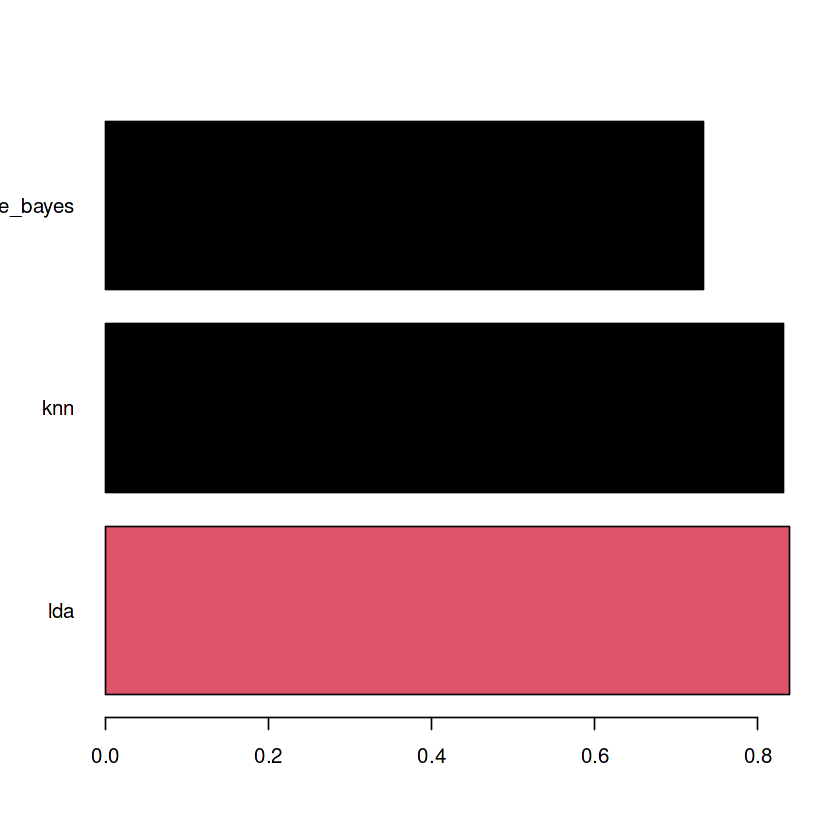

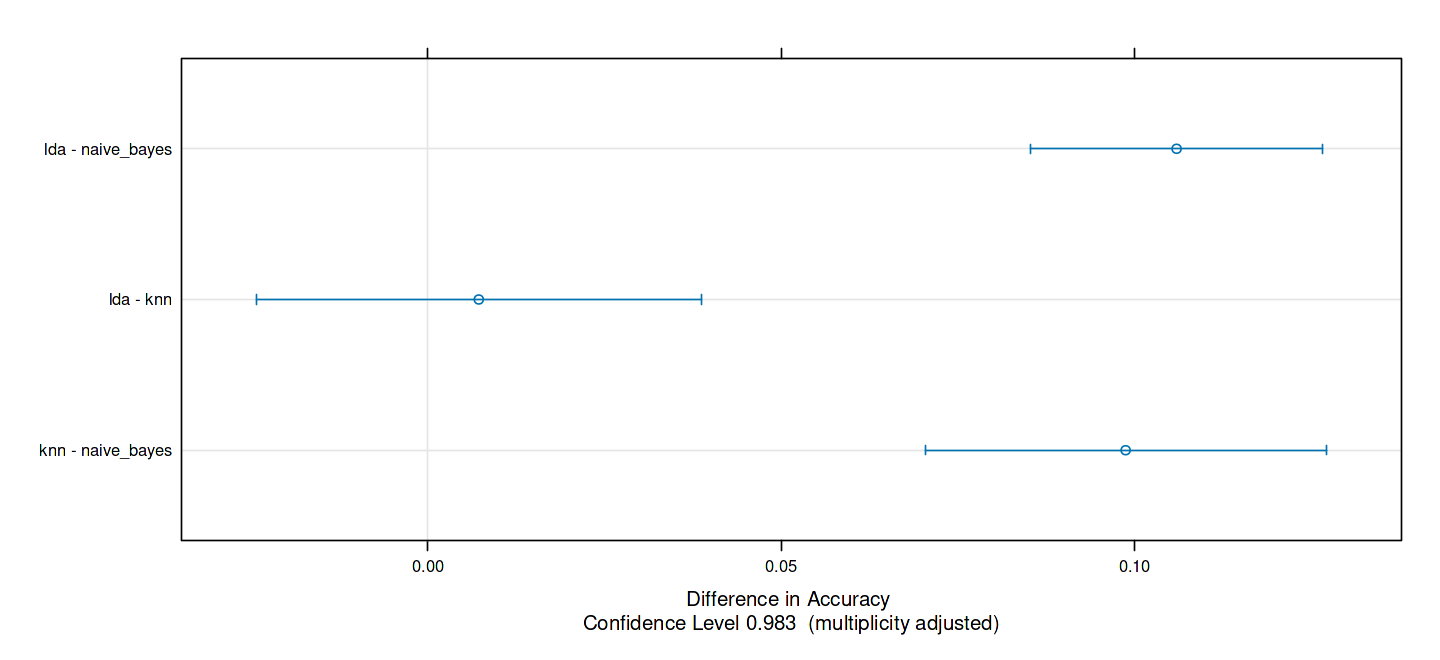

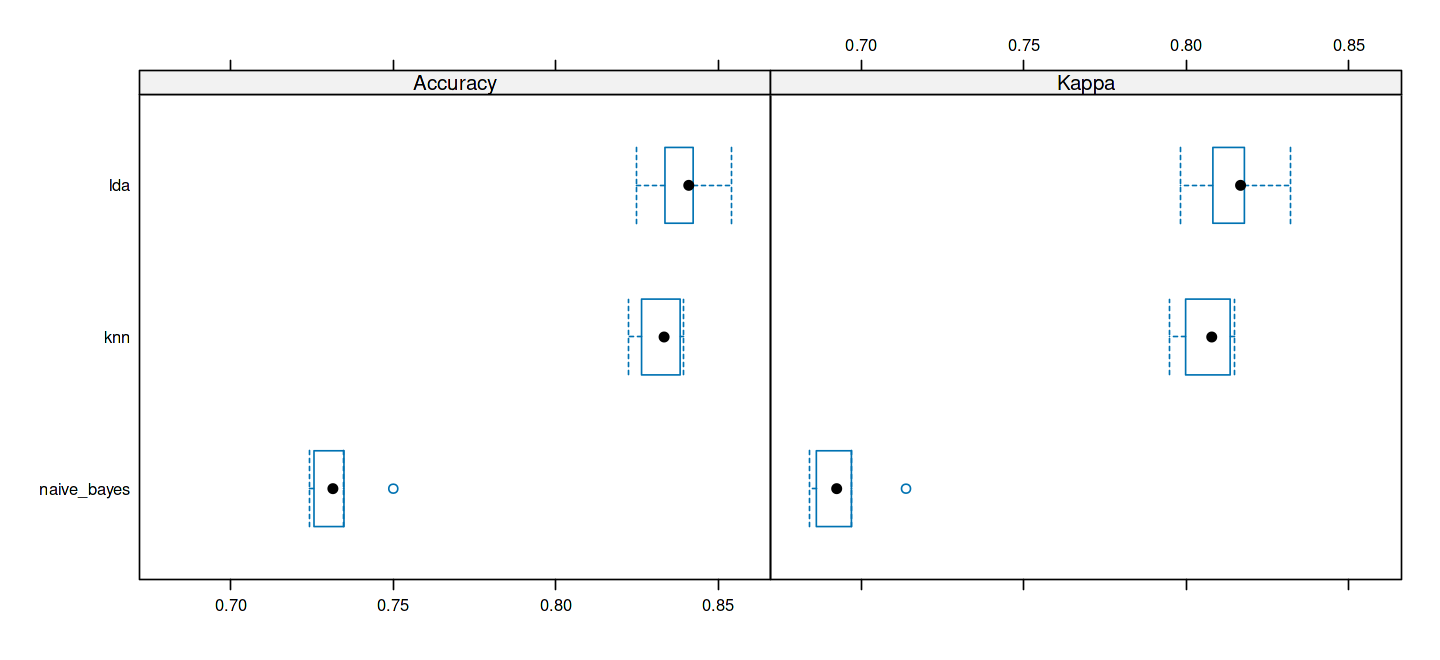

In [21]:
# visualise model performance
# This was taken from previous assignment about Voice Recognition

models = list(
    lda = fit_lda, 
    knn = fit_knn, 
    # qda = fit_qda,
    naive_bayes = fit_nb
    # mr = fit_multinom
)

#obtain the accuracies from each model
Acc = sapply(models, function(mdl) caret::getTrainPerf(mdl)[['TrainAccuracy']]) 

#barplot of all model accuracies, the best model is in red
color = 1 + (Acc >= max(Acc)) 
barplot(Acc, horiz=T, las=1, col = color)


options(width=120, repr.plot.width=12, repr.plot.height=5.5, digits=5)

# Extract the fold statistics for each model
rs <- resamples(models)

summary(rs)

# Compute the table of pairwise comparisons
# CIs/p-values for paired differences (Accuracy and Kappa)
summary(diff(rs))   
dotplot(diff(rs))

# box-and-whisker plot for the performance distribution
bwplot(rs)

The plots suggest that the cross-validated prediction accuracy of LDA is the highest, with KNN performing slightly worse. Both models perform significantly better than Naive Bayes.

To detect whether model performance is improved if we exclude the no activity ("-") case, we code a CV procedure that excludes no activity cases in the training set but includes them in the test set.

In [22]:
cv_no_activity <- function(df, k, method) {
    # get folds
    folds <- createFolds(df$activity, k = k, returnTrain = TRUE)

    acc <- numeric(length(folds))
    for (i in seq_along(folds)) {
        train_dat <- df[folds[[i]], ] |> 
            filter(activity != "-") # drop no activity from training set
        test_dat <- df[-folds[[i]], ]

        # fit model 
        if (method == "multinom") { # suppress messages when fitting multinomial regression
            fit <- train(
                activity ~ ., 
                data = train_dat, 
                method = method, 
                trControl = trainControl("none"), 
                trace = FALSE
            )
        } else if (method == "naive_bayes"){ # make sure that NB only fits one model
            fit <- train(
                activity ~ ., 
                data = train_dat, 
                method = method, 
                trControl = trainControl("none"), 
                # ==> START LLM
                tuneGrid = data.frame(laplace = 0, usekernel = TRUE, adjust = 1)
                # ==> END LLM
            )
        } else {
            fit <- train(
                activity ~ ., 
                data = train_dat, 
                method = method, 
                trControl = trainControl("none")
            )
        }
        acc[i] <- mean(predict(fit, test_dat) == test_dat$activity)
    }
    return(mean(acc))
}

In [23]:
# apply cv_no_activity to different methods
methods <- c("lda", "knn", "naive_bayes")
sapply(methods, cv_no_activity, df = myData2, k = 5)

lda         knn naive_bayes 
    0.72711     0.70807     0.63701

So, excluding the no activity cases does not seem to improve performance when there are such cases in the test set. Below, we want to assess model performance with increasing complexity (increasing number of features). To this end, we select features to include based on p-values in an ANOVA when performing cross-validation. We incrementally increase the number of features that are selected and show a plot that includes differnt models. Note that QDA is prone to fail as well as multinomial regression for a large number of features, so these methods are not or only partially included in the plot below.

In [24]:
# Below we perform CV with feature selection in each fold. 
# We do so for different complexities (number of features) and plot the results.

# Most of the code taken from Music genre recognition notebook
# Feature selection function
extract_p_anova <- function(IV, DV) {
    IV <- as.factor(IV)
    anova_fit <- aov(DV ~ IV)
    p_val <- summary(anova_fit)[[1]][["Pr(>F)"]][1]
    return(p_val)
}


cv_feature <- function(df, k, n_features, method) {
    # get folds
    folds <- createFolds(df$activity, k = k, returnTrain = TRUE)

    # CV including feature selection
    acc <- numeric(length(folds))
    for (i in seq_along(folds)) {
        train_data <- df[folds[[i]], ]
        test_data  <- df[-folds[[i]], ]
        
        # apply feature selection code from earlier on training set 
        pvals <- train_data |> select(-activity) |> sapply(extract_p_anova, IV = train_data$activity)
        selected <- pvals |> sort() |> head(n_features) |> names()
        
        # restrict to selected variables + outcome 
        train_sel <- train_data |> select(all_of(c(selected, "activity")))
        test_sel  <- test_data |> select(all_of(c(selected, "activity")))
        
        # fit model 
        if (method == "multinom") { # suppress messages when fitting multinomial regression
            fit <- tryCatch(
                train(
                    activity ~ ., 
                    data = train_sel, 
                    method = method, 
                    trControl = trainControl("none"), 
                    trace = FALSE
                ),
                warning = function(w) NA,
                error = function(e) NA
            )
        } else if (method == "naive_bayes"){ # make sure that NB only fits one model
            fit <- train(
                activity ~ ., 
                data = train_sel, 
                method = method, 
                trControl = trainControl("none"), 
                # ==> START LLM
                tuneGrid = data.frame(laplace = 0, usekernel = TRUE, adjust = 1)
                # ==> END LLM
            )
        } else {
            fit <- train(
                activity ~ ., 
                data = train_sel, 
                method = method, 
                trControl = trainControl("none")
            )
        }
        
        # predict & store accuracy
        if(anyNA(fit)) {
            acc[i] <- NA
        } else {
            acc[i] <- mean(predict(fit, test_sel) == test_sel$activity)
        }
    }
    
    return(mean(acc))
}

In [25]:
# Run function for different complexities
# Note: make sure that no PCA has been performed on the feature data frame
# Remove non-feature columns
myData2 = new_Data |> 
    select(-c("epoch","sampleid","user_id","exp_id","n_samples")) |>
    drop_na()

# without PCA
preproc = preProcess(
    myData2, 
    method=c("nzv", "corr", "center", "scale", "medianImpute"), 
    cutoff=0.95
)
myData2 = predict(preproc, myData2)

lincomb = myData2 |> select_if(is.numeric) |> findLinearCombos()
redundant = names(myData2 |> select_if(is.numeric))[lincomb$remove]
myData2 = myData2 |> select(-all_of(redundant))

n_features <- seq(80, 180, by = 10)
mean_accs_lda <- sapply(n_features, cv_feature, df = myData2, k = 5, method = "lda")
mean_accs_knn <- sapply(n_features, cv_feature, df = myData2, k = 5, method = "knn")
mean_accs_nb <- sapply(
    n_features, 
    cv_feature, 
    df = myData2, 
    k = 5, 
    method = "naive_bayes"
)

acc_list <- list(
    LDA = data.frame(mean_accs = mean_accs_lda),
    KNN = data.frame(mean_accs = mean_accs_knn),
    NB = data.frame(mean_accs = mean_accs_nb)
)

print(acc_list)

$LDA
   mean_accs
1    0.80858
2    0.81450
3    0.82043
4    0.82874
5    0.82859
6    0.82618
7    0.83146
8    0.83339
9    0.83835
10   0.83659
11   0.83852

$KNN
   mean_accs
1    0.82762
2    0.83482
3    0.83243
4    0.84395
5    0.83836
6    0.84043
7    0.83867
8    0.83851
9    0.83419
10   0.83052
11   0.83067

$NB
   mean_accs
1    0.72679
2    0.72984
3    0.72806
4    0.73350
5    0.73655
6    0.73383
7    0.73368
8    0.73896
9    0.73431
10   0.73528
11   0.73256



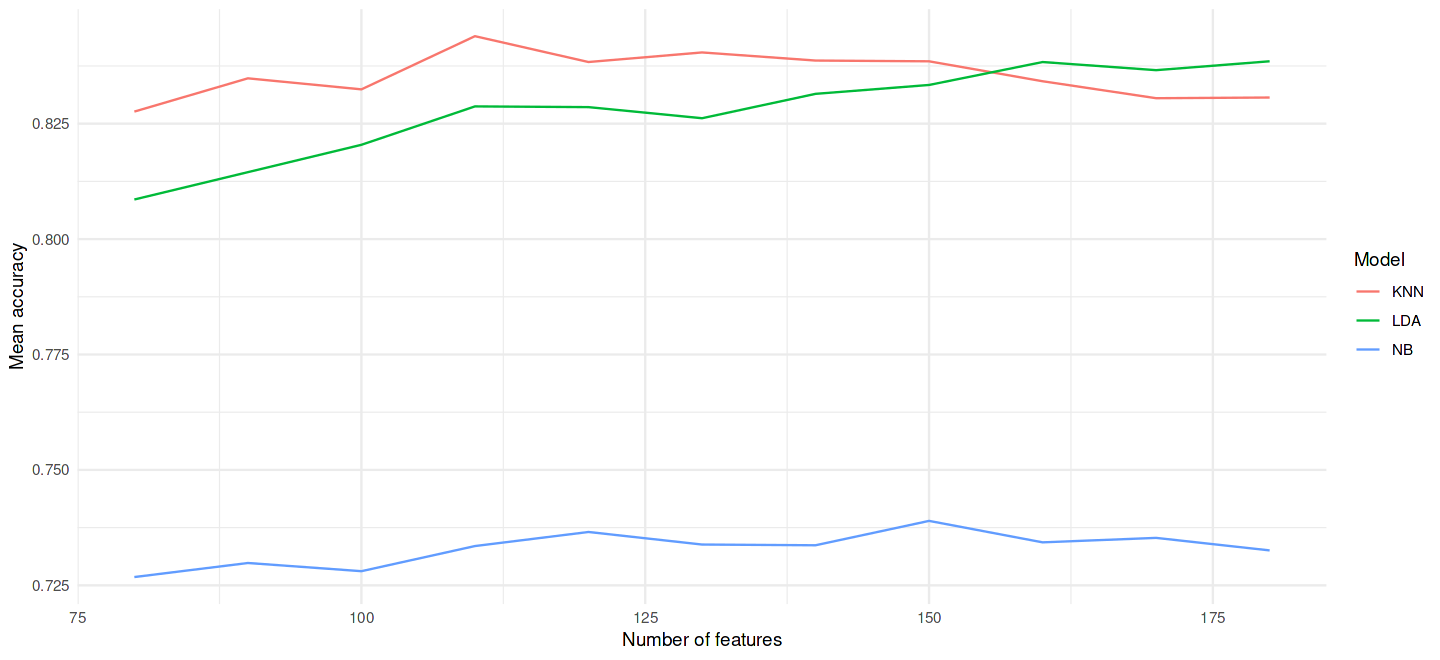

In [26]:
acc_list |> 
    list_rbind(names_to = "Model") |> # bind to df
    mutate(n_features = rep(n_features, length(acc_list))) |> # add n_features
    ggplot(aes(y = mean_accs, x = n_features, col = Model)) +
    geom_line() +
    labs(
        x = "Number of features",
        y = "Mean accuracy"
    ) +
    theme_minimal()

In this plot, KNN is the best predictor until approximately 160 predictors are included. After this, LDA performs the best, thus we opt for LDA with all predictors. Furthermore, there doesn't seem to be a drop in performance when including all predictors.

### 

<h1 style="background-color:#A80828; color:white; padding:12px; border-radius:8px; font-size:24px; font-weight:bold;">5. Submissions</h1>

In [27]:
filenames_test = list.files("./RawData/Test/", pattern = "^acc", full.names = TRUE)
filenames_test
filenames_test_gyro <- dir("./RawData/Test/", pattern = "^gyro", full.names = TRUE)
filenames_test_gyro

[1] "./RawData/Test//acc_exp03_user02.txt" "./RawData/Test//acc_exp04_user02.txt"
 [3] "./RawData/Test//acc_exp07_user04.txt" "./RawData/Test//acc_exp08_user04.txt"
 [5] "./RawData/Test//acc_exp17_user09.txt" "./RawData/Test//acc_exp18_user09.txt"
 [7] "./RawData/Test//acc_exp19_user10.txt" "./RawData/Test//acc_exp20_user10.txt"
 [9] "./RawData/Test//acc_exp21_user10.txt" "./RawData/Test//acc_exp24_user12.txt"
[11] "./RawData/Test//acc_exp25_user12.txt" "./RawData/Test//acc_exp26_user13.txt"
[13] "./RawData/Test//acc_exp27_user13.txt" "./RawData/Test//acc_exp36_user18.txt"
[15] "./RawData/Test//acc_exp37_user18.txt" "./RawData/Test//acc_exp40_user20.txt"
[17] "./RawData/Test//acc_exp41_user20.txt" "./RawData/Test//acc_exp48_user24.txt"
[19] "./RawData/Test//acc_exp49_user24.txt"

[1] "./RawData/Test//gyro_exp03_user02.txt" "./RawData/Test//gyro_exp04_user02.txt"
 [3] "./RawData/Test//gyro_exp07_user04.txt" "./RawData/Test//gyro_exp08_user04.txt"
 [5] "./RawData/Test//gyro_exp17_user09.txt" "./RawData/Test//gyro_exp18_user09.txt"
 [7] "./RawData/Test//gyro_exp19_user10.txt" "./RawData/Test//gyro_exp20_user10.txt"
 [9] "./RawData/Test//gyro_exp21_user10.txt" "./RawData/Test//gyro_exp24_user12.txt"
[11] "./RawData/Test//gyro_exp25_user12.txt" "./RawData/Test//gyro_exp26_user13.txt"
[13] "./RawData/Test//gyro_exp27_user13.txt" "./RawData/Test//gyro_exp36_user18.txt"
[15] "./RawData/Test//gyro_exp37_user18.txt" "./RawData/Test//gyro_exp40_user20.txt"
[17] "./RawData/Test//gyro_exp41_user20.txt" "./RawData/Test//gyro_exp48_user24.txt"
[19] "./RawData/Test//gyro_exp49_user24.txt"

<h2 style="background-color:#C91E3A; color:white; padding:10px; border-radius:6px; font-size:20px; font-weight:normal;">5.1 Formatting the submission file</h2>

In [28]:
#Apply functions to test data

# accelerometer
myDataTimeDom_test = map_dfr(filenames_test, extractTimeDomainFeatures, sample_labels) 
myDataFreq_test = map_dfr(filenames_test, extractFrequencyDomainFeatures, sample_labels)
myDataStats_test = map_dfr(filenames_test, extractStatFeatures, sample_labels)

# gyroscope
myDataTimeDom_test_gyro <- map_dfr(filenames_test_gyro, extractTimeDomainFeatures, sample_labels) 
myDataFreq_test_gyro <- map_dfr(filenames_test_gyro, extractFrequencyDomainFeatures, sample_labels)
myDataStats_test_gyro <- map_dfr(filenames_test_gyro, extractStatFeatures, sample_labels)

myTestData <- myDataStats_test %>%
    left_join(
        myDataTimeDom_test, 
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity")
    ) %>%
    left_join(
        myDataFreq_test, 
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity")
    ) %>%
    left_join(
        myDataStats_test_gyro, 
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity"),
        suffix = c("", "_gyro") # different colnames for gyro features
    ) %>% 
    left_join(
        myDataTimeDom_test_gyro,
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity"),
        suffix = c("", "_gyro")
    ) %>%
    left_join(
        myDataFreq_test_gyro, 
        by = c("epoch", "user_id", "sampleid", "exp_id", "n_samples", "activity"),
        suffix = c("", "_gyro")
    ) %>%
    relocate(n_samples, .after = last_col())

# Apply data transformation
myTestData2 = predict(preproc, myTestData)
myTestData2 = myTestData2 |> select(-all_of(redundant))

# Apply best model to predict activity
predicted_activity = predict(fit_lda, myTestData2)

# Writing the test predictions to CSV file
myTestData |>

    # Set `activity` to the predicted activity
    mutate(activity = predicted_activity) |>

    # prepend "user" and "exp" to user_id and exp_id
    mutate(
        user_id = paste(ifelse(user_id < 10, "user0", "user"), user_id, sep=""), 
        exp_id = paste(ifelse(exp_id < 10, "exp0", "exp"), exp_id, sep="")
    ) |> 

    # unite columnes user_id, exp_id and sample_id into a string 
    # separated by "_" and store it in the new variable `Id`
    unite(Id, user_id, exp_id, sampleid) |>

    # retain only the `Id` and  predictions
    select(Id, Predicted = activity) |>

    # write to file
    write_csv("submission.csv")


# Check the result: print first 20 lines in the submission file
cat(readLines("submission.csv",20), sep="\n")

Warning message:
“There were 3 warnings in `summarise()`.
The first warning was:
ℹ In argument: `AR1_X2_lag2 = lagged_cor(X2, lag = 2)`.
ℹ In group 139: `epoch = 138`.
Caused by warning in `cor()`:
! the standard deviation is zero
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”


Id,Predicted
user02_exp03_0,-
user02_exp03_128,-
user02_exp03_256,-
user02_exp03_384,STANDING
user02_exp03_512,STANDING
user02_exp03_640,STANDING
user02_exp03_768,STANDING
user02_exp03_896,STANDING
user02_exp03_1024,STANDING
user02_exp03_1152,STANDING
user02_exp03_1280,STANDING
user02_exp03_1408,-
user02_exp03_1536,STANDING
user02_exp03_1664,STANDING
user02_exp03_1792,SITTING
user02_exp03_1920,SITTING
user02_exp03_2048,SITTING
user02_exp03_2176,SITTING
user02_exp03_2304,SITTING


<h1 style="background-color:#A80828; color:white; padding:12px; border-radius:8px; font-size:24px; font-weight:bold;">6. Division of labour</h1>

We split up feature extraction: Kitty worked on statistical features, Oliver worked on time domain features and Julian worked on frequency domain features. Model fitting comparison and prediction was split up equally and worked on together. Formatting was done by Kitty and Oliver. Multinomial regression with CV and feature selection was done by Julian.

<h1 style="background-color:#A80828; color:white; padding:12px; border-radius:8px; font-size:24px; font-weight:bold;">7. References</h1>
Grasman, R. (2018). Feature extraction from signals. <br>https://www.dropbox.com/scl/fi/5khqukcdicec83cfwylc7/Feature-extraction-from-Signals.paper?rlkey=slhhurouc1b60e1u6bmzji0nl&dl=0
<br>
<br>
Jalal, A., Quaid, M. A., Tahir, S. B., & Kim, K. (2020a). A study of accelerometer and gyroscope measurements in physical life-log activities detection systems. Sensors, 20(22), 6670. <br>https://doi.org/10.3390/s20226670 
<br>
<br>
Inspiration came from a variety of places during the third round, including group 5 for some statistical features, and group 3 for formatting.